# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import os
import json
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

%pylab inline

Populating the interactive namespace from numpy and matplotlib


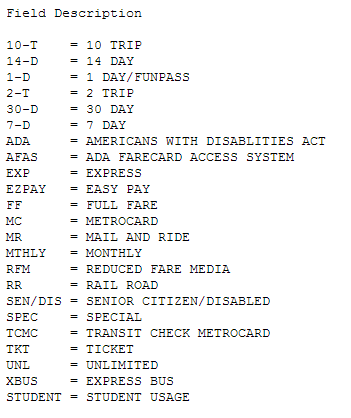

In [3]:
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [2]:
print (os.getenv("PUIDATA") + "/" + "MTA_Fare.npy")

/home/cusp/skk456/PUIdata/MTA_Fare.npy


In [2]:
df = np.load(os.getenv("PUIDATA") + "/" + "MTA_Fare.npy")

In [3]:
df.shape

(600, 23, 194)

In [4]:
df[:,:,1]

array([[64703,  2083,   276, ...,     0,     0,    -1],
       [20179,   647,    43, ...,     0,     0,    -1],
       [ 3429,    92,     6, ...,     0,     0,    -1],
       ..., 
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1]], dtype=int32)

In [5]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [6]:
df = df.astype('float')
df[df == (-1)] = 'nan'

In [7]:
date1 = pd.date_range(start = '05/21/2010', end = '01/31/2014',freq = '7D')
date1

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='7D')

In [8]:
df1 = df.reshape(13800,194)

In [9]:
df_pd1 = pd.DataFrame(df1, index = None, columns = date1)

In [10]:
df_pd1 = df_pd1.dropna(axis = 0, how = 'all')

In [11]:
df_pd1 = df_pd1.transpose()

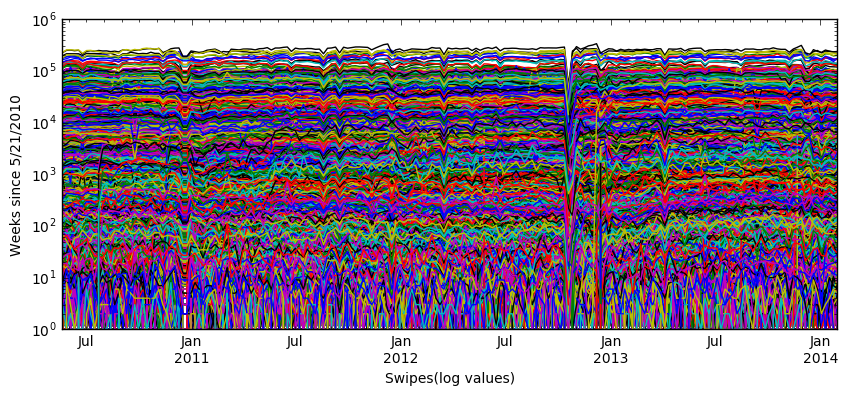

In [12]:
ax = df_pd1.plot(logy = True, legend = None, figsize = (10,4))
ax.set(xlabel='Swipes(log values)', ylabel='Weeks since 5/21/2010')

#### Figure 1: Swipes (log) per card type for each station per week

In [13]:
df_sum1 = np.nansum(df, axis = 1)
df_mean1 = np.nanmean(df_sum1, axis = 0)
df_mean1.shape

(194,)

In [14]:
df_pd1['mean'] = df_mean1

In [15]:
df_pd1.head()

,0,1,2,3,4,5,6,7,8,9,...,12664,12665,12666,12667,12668,12669,12670,12671,12672,mean
2010-05-21,56961.0,1732.0,203.0,883.0,358.0,17654.0,32369.0,59.0,6733.0,1835.0,...,0.0,0.0,0.0,0.0,202.0,0.0,0.0,0.0,NaN,44533.778333
2010-05-28,64703.0,2083.0,276.0,958.0,529.0,20249.0,42599.0,60.0,5487.0,2320.0,...,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,NaN,48776.618333
2010-06-04,68002.0,2107.0,245.0,976.0,422.0,20325.0,41423.0,67.0,6237.0,2521.0,...,0.0,0.0,0.0,0.0,135.0,0.0,0.0,0.0,NaN,49335.315000
2010-06-11,72628.0,2188.0,280.0,987.0,261.0,20852.0,42667.0,61.0,7272.0,2759.0,...,0.0,0.0,0.0,0.0,173.0,0.0,0.0,0.0,NaN,48979.320000
2010-06-18,75866.0,2314.0,265.0,1012.0,248.0,20079.0,42415.0,51.0,7752.0,2673.0,...,0.0,0.0,0.0,10.0,228.0,0.0,0.0,0.0,NaN,48642.946667


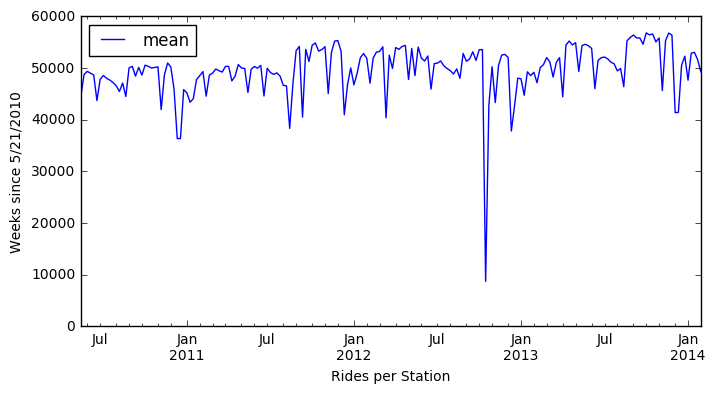

In [16]:
ax = df_pd1.reset_index().plot(x='index', y='mean', figsize=(8,4))
ax.set(xlabel='Rides per Station', ylabel='Weeks since 5/21/2010')

In [17]:
thresholds = [df_pd1['mean'].mean() + 3 * df_pd1['mean'].std(), 
              df_pd1['mean'].mean() - 3 * df_pd1['mean'].std()]
thresholds

[64593.987625626447, 34677.178611486954]

In [18]:
df_pd1.loc[(df_pd1['mean'] < thresholds[1])]

,0,1,2,3,4,5,6,7,8,9,...,12664,12665,12666,12667,12668,12669,12670,12671,12672,mean
2012-10-19,11409.0,255.0,40.0,123.0,2.0,5083.0,3151.0,0.0,0.0,0.0,...,0.0,0.0,0.0,481.0,64.0,0.0,0.0,0.0,0.0,8697.81


### The week when there was a significant drop in the number of rides in New York started on October 19th, 2012. The Sandy hurricance also happened during the same week, explaining the significant drop that we observe.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [19]:
df_sum2 = np.nansum(df, axis=0)

In [20]:
df_sum2[22].shape

(194,)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


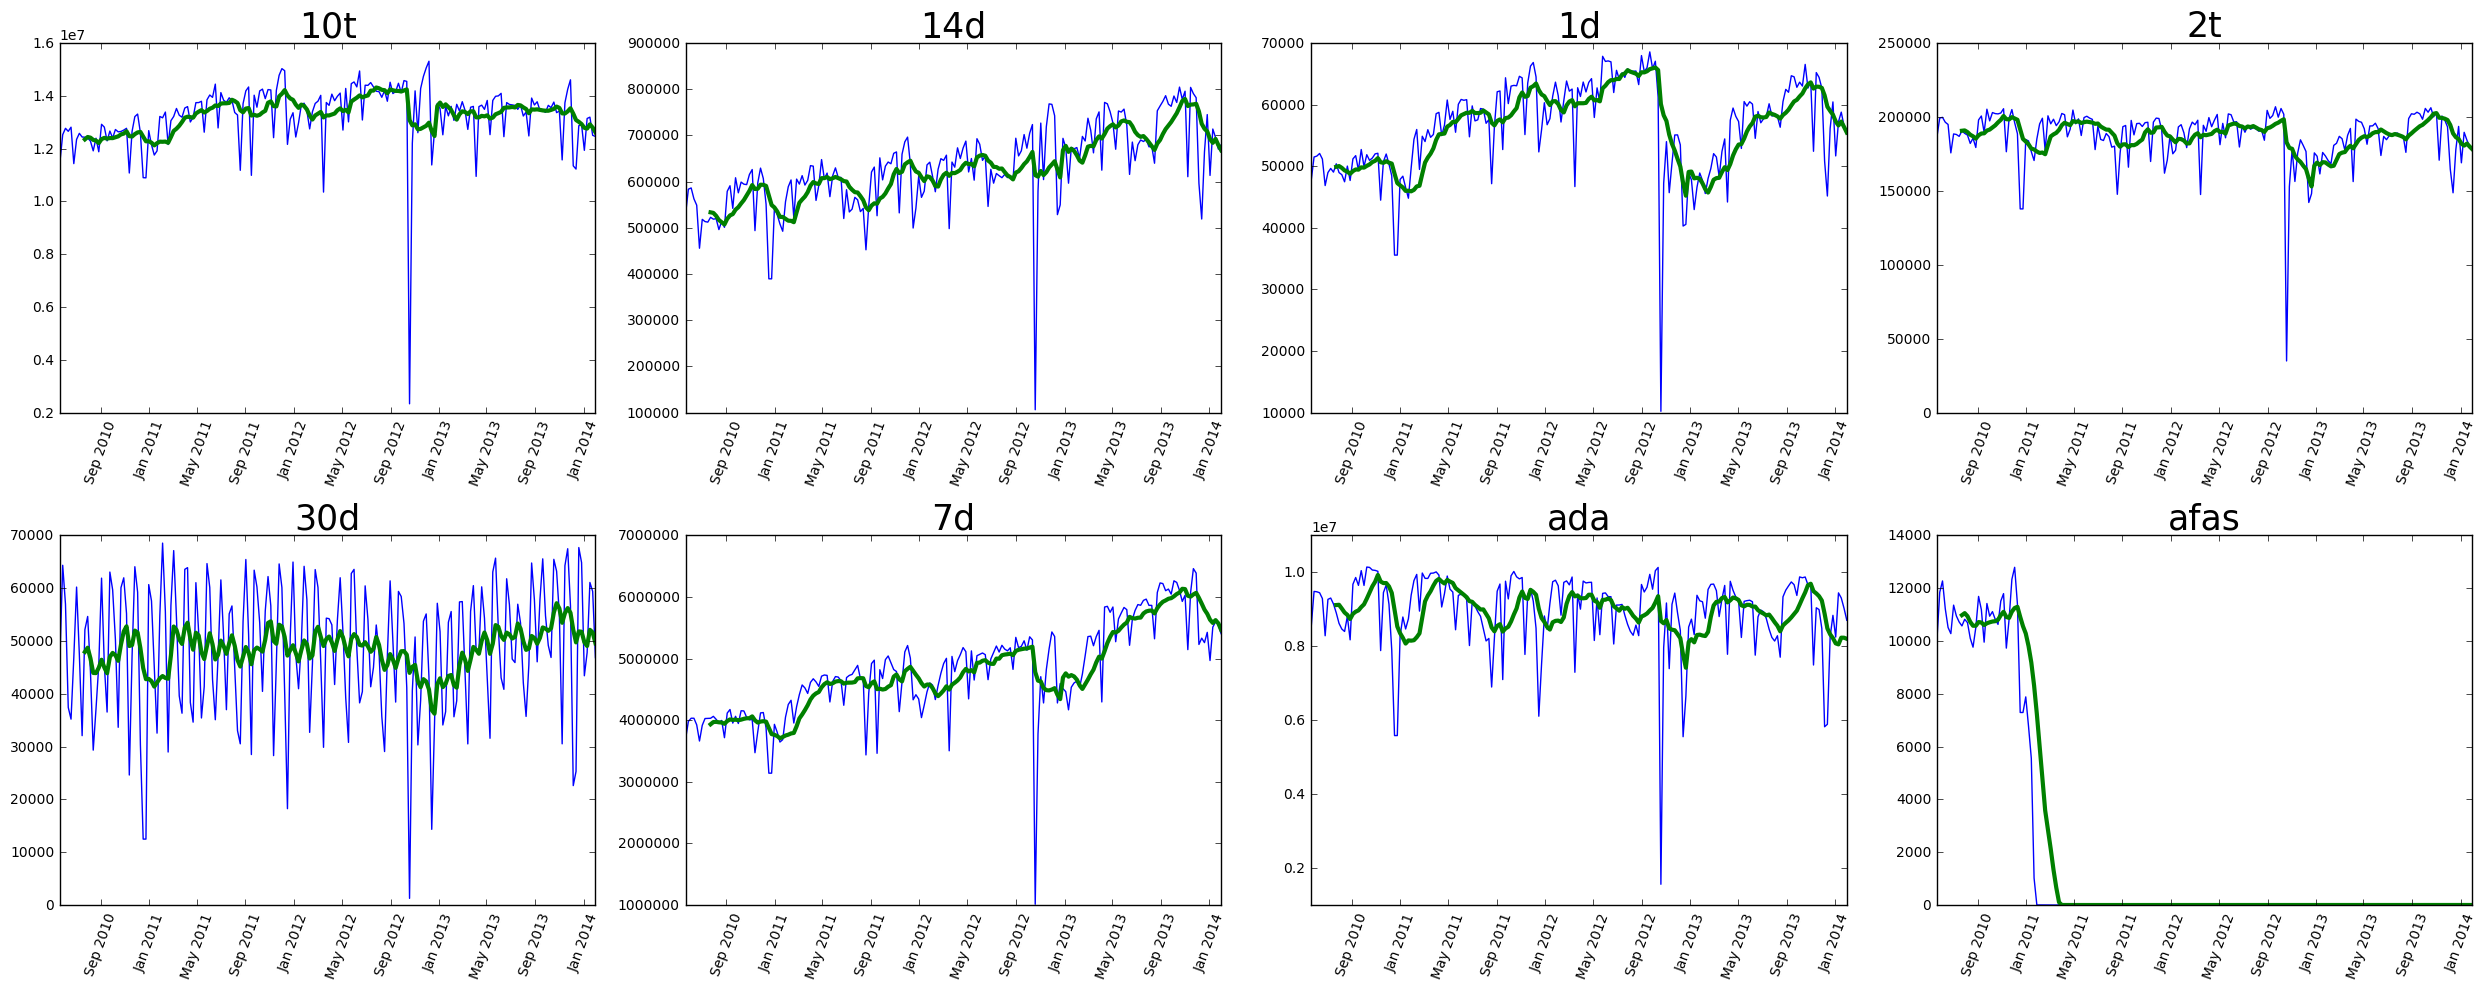

In [21]:
fig1 = pl.figure(figsize = (25, 10))
ax1=[0] * 8

ax1[0] = fig1.add_subplot(241)
ax1[1] = fig1.add_subplot(242)
ax1[2] = fig1.add_subplot(243)
ax1[3] = fig1.add_subplot(244)
ax1[4] = fig1.add_subplot(245)
ax1[5] = fig1.add_subplot(246)
ax1[6] = fig1.add_subplot(247)
ax1[7] = fig1.add_subplot(248)

for i, a in enumerate(range(8)):
    ax1[i].plot(date1, df_sum2[a], '-')  
    ax1[i].plot(date1, pd.rolling_mean(df_sum2[a], 10),'g', lw = 3)
    ax1[i].set_title(ridetype[a], fontsize = 25)
    pl.setp(ax1[i].xaxis.get_majorticklabels(), rotation=70 )

fig1.tight_layout()

#### Figure 3: Number of rides per week since 05/21/2010 with rolling mean (window = 10 weeks) for each ridership type

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


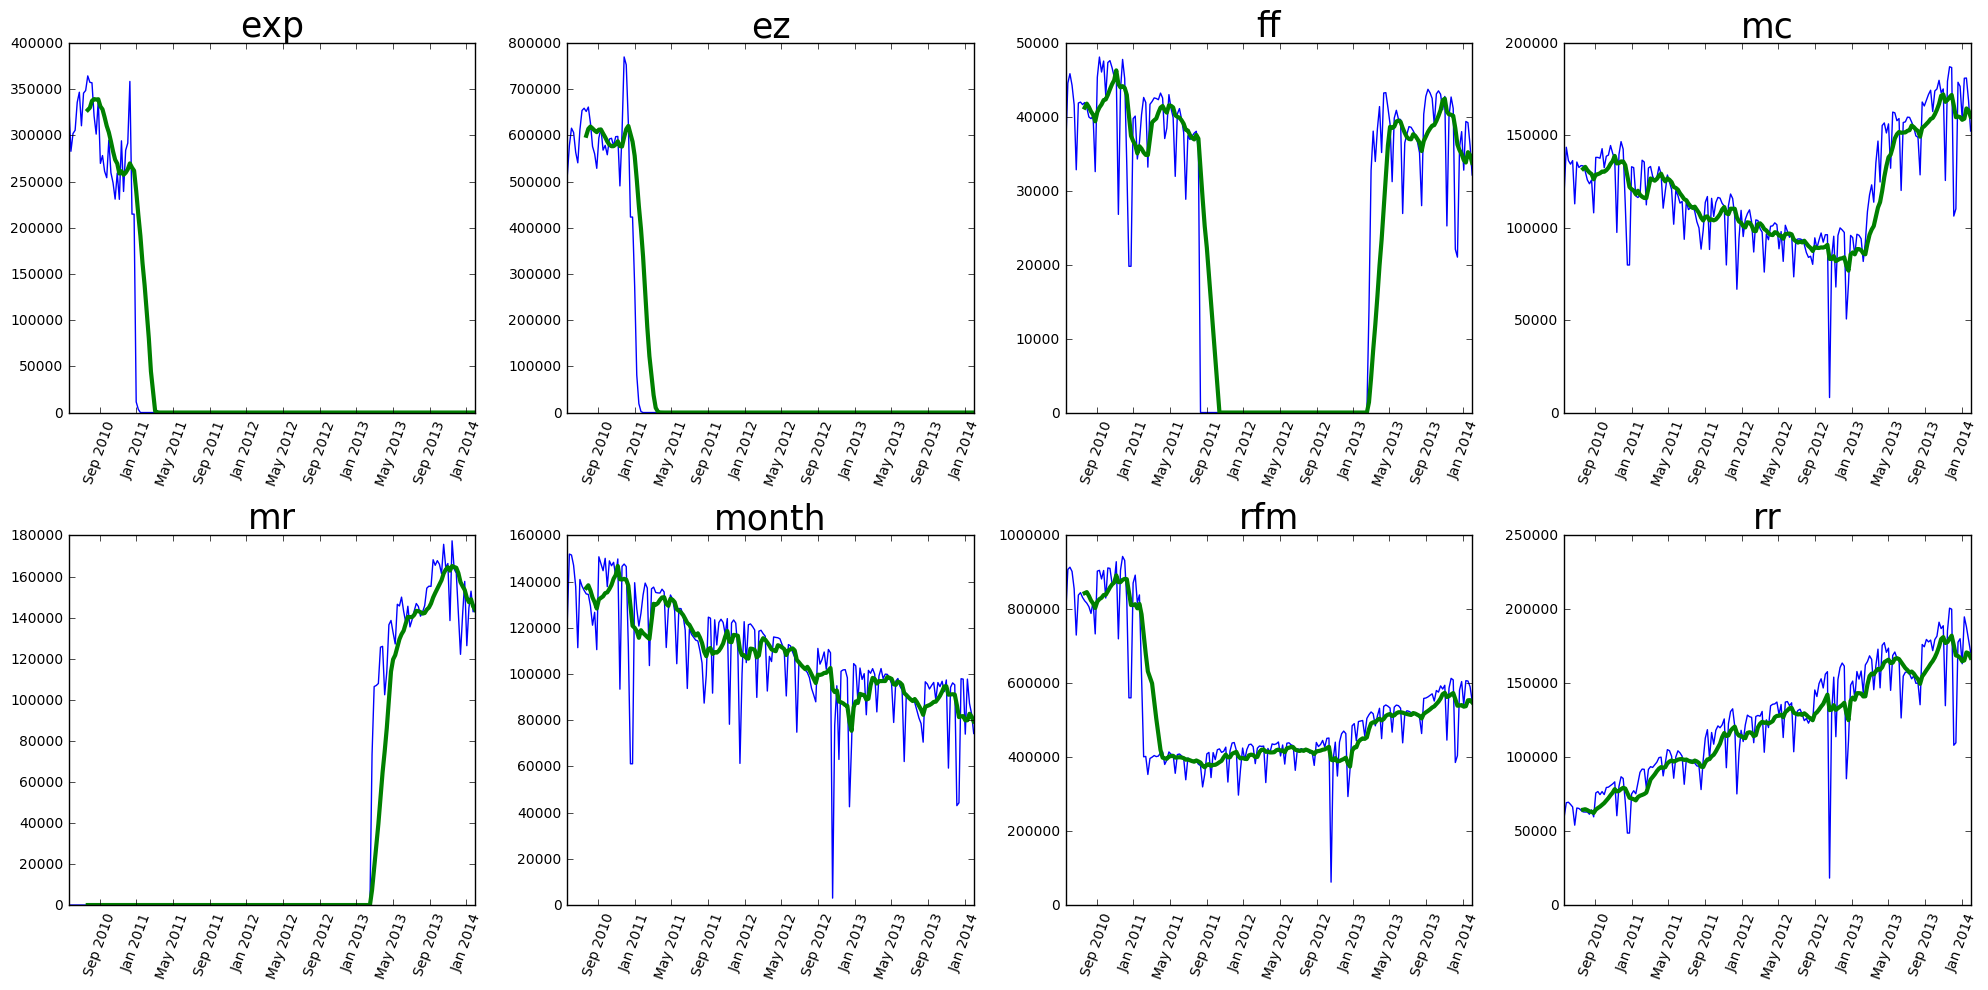

In [22]:
fig2 = pl.figure(figsize = (20, 10))
ax2=[0] * 8

ax2[0] = fig2.add_subplot(241)
ax2[1] = fig2.add_subplot(242)
ax2[2] = fig2.add_subplot(243)
ax2[3] = fig2.add_subplot(244)
ax2[4] = fig2.add_subplot(245)
ax2[5] = fig2.add_subplot(246)
ax2[6] = fig2.add_subplot(247)
ax2[7] = fig2.add_subplot(248)

for i, a in enumerate(range(8,16)):
    ax2[i].plot(date1, df_sum2[a], '-')
    ax2[i].plot(date1, pd.rolling_mean(df_sum2[a], 10),'g', lw = 3)
    ax2[i].set_title(ridetype[a], fontsize = 25)
    pl.setp( ax2[i].xaxis.get_majorticklabels(), rotation=70 )

fig2.tight_layout()

#### Figure 4: Number of rides per week since 05/21/2010 with rolling mean (window = 10 weeks) for each ridership type

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


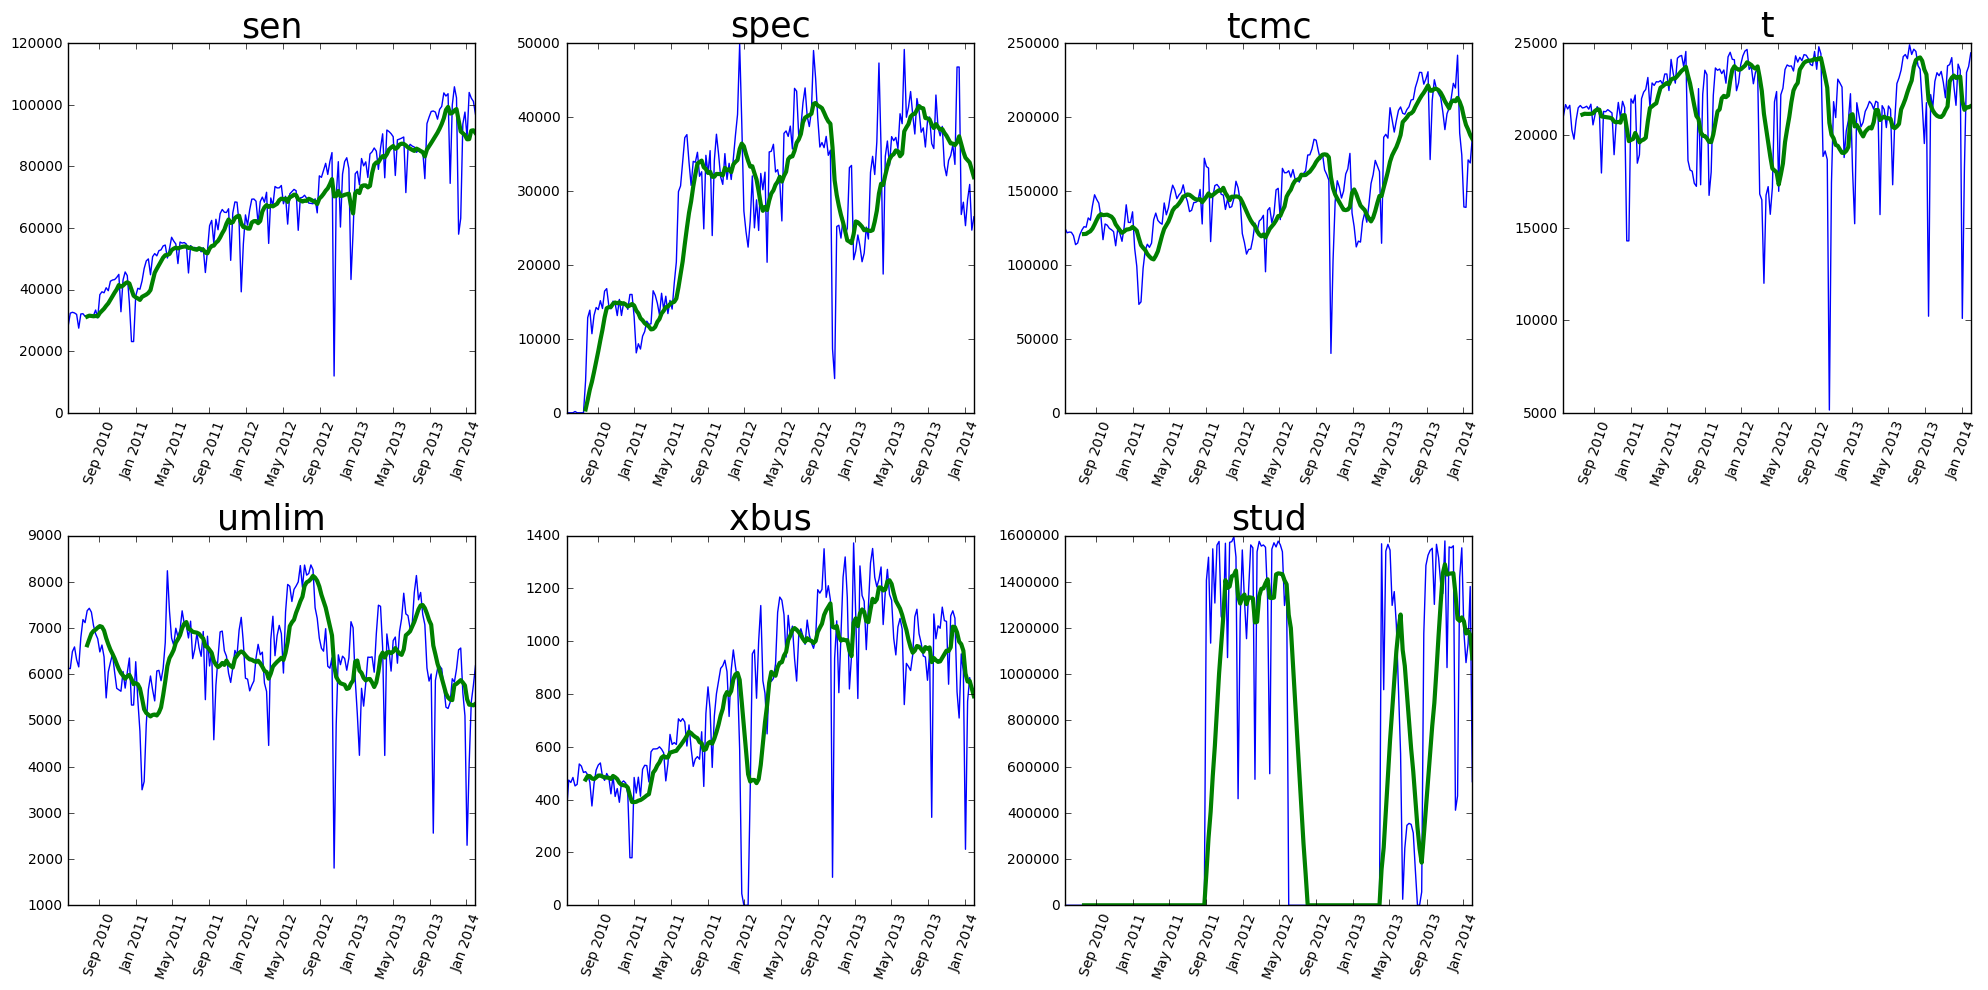

In [37]:
fig3 = pl.figure(figsize = (20, 10))
ax3=[0] * 8

ax3[0] = fig3.add_subplot(241)
ax3[1] = fig3.add_subplot(242)
ax3[2] = fig3.add_subplot(243)
ax3[3] = fig3.add_subplot(244)
ax3[4] = fig3.add_subplot(245)
ax3[5] = fig3.add_subplot(246)
ax3[6] = fig3.add_subplot(247)

for i, a in enumerate(range(16,23)):
    ax3[i].plot(date1, df_sum2[a], '-')
    ax3[i].plot(date1, pd.rolling_mean(df_sum2[a], 10),'g', lw = 3)
    ax3[i].set_title(ridetype[a], fontsize = 25)
    pl.setp( ax3[i].xaxis.get_majorticklabels(), rotation=70 )

fig3.tight_layout()

#### Figure 5: Number of rides per week since 05/21/2010 with rolling mean (window = 10 weeks) for each ridership type

Based on the graphs, the ridership types are categorized into the following categories:

- Downward trend: month
- Stationary: 10t, 14d, 1d, 2t, 30d,ada, ff, mc, rfm, t, umlim, stud
- Upward trend: 7d, rr, spec, tcmc, sen, xbus. 

The series afas, exp, ez, mr cannot be identified because of missing data.

#### In the following part, I group the series into three parts by evaluateing the ratio of the sum of rides in first 10 weeks over that of last 10 weeks

In [23]:
ratio_usage = []
for i in range(23):
    r = df_sum2[i][:10].sum()/df_sum2[i][-10:].sum()
    ratio_usage.append(r)

In [24]:
ratio_pd = pd.DataFrame(ratio_usage, columns = ['ratio'])
ratio_pd['ride_type'] = ridetype
ratio_pd.head()

,ratio,ride_type
0,0.978667,10t
1,0.798681,14d
2,0.899810,1d
3,1.070889,2t
4,0.967317,30d


In [25]:
ratio_pd = ratio_pd.sort(['ratio'], ascending= [True])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


#### I use 0.7 and 1.6 as the the threshold values for grouping. The results are quite similar to the results I got by looking at the graph except for the ones I couldn't identify because of missing data. The only difference is the 7d rides which I categoried as upward trend based on the graph but stationary based on my threshold value for the ratio of usage. The reason is that I only compare the first 10 weeks and the last 10 weeks and didn't consider the missing data during the in-between period.

In [26]:
stationary = ratio_pd[(ratio_pd['ratio'] >0.7) & (ratio_pd['ratio'] < 1.6)]
downward = ratio_pd[ratio_pd['ratio'] >= 1.6]
upward = ratio_pd[ratio_pd['ratio'] <= 0.7]

In [27]:
stationary.head()

,ratio,ride_type
5,0.719555,7d
1,0.798681,14d
11,0.824035,mc
2,0.899810,1d
4,0.967317,30d


In [44]:
downward.head()

,ratio,ride_type
13,1.727944,month
7,4774.478261,afas
8,93571.342857,exp
9,665798.555556,ez


In [45]:
upward.head()

,ratio,ride_type
22,0.000000,stud
12,0.000040,mr
17,0.014249,spec
16,0.343714,sen
15,0.385660,rr


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [28]:
df_sum3 = np.nansum(df_sum1, axis = 1)

In [29]:
df_sum3.shape

(600,)

In [30]:
1/52

0.019230769230769232

In [49]:
N = 194
np.fft.rfftfreq(N, 1.0)

array([ 0.        ,  0.00515464,  0.01030928,  0.01546392,  0.02061856,
        0.0257732 ,  0.03092784,  0.03608247,  0.04123711,  0.04639175,
        0.05154639,  0.05670103,  0.06185567,  0.06701031,  0.07216495,
        0.07731959,  0.08247423,  0.08762887,  0.09278351,  0.09793814,
        0.10309278,  0.10824742,  0.11340206,  0.1185567 ,  0.12371134,
        0.12886598,  0.13402062,  0.13917526,  0.1443299 ,  0.14948454,
        0.15463918,  0.15979381,  0.16494845,  0.17010309,  0.17525773,
        0.18041237,  0.18556701,  0.19072165,  0.19587629,  0.20103093,
        0.20618557,  0.21134021,  0.21649485,  0.22164948,  0.22680412,
        0.23195876,  0.2371134 ,  0.24226804,  0.24742268,  0.25257732,
        0.25773196,  0.2628866 ,  0.26804124,  0.27319588,  0.27835052,
        0.28350515,  0.28865979,  0.29381443,  0.29896907,  0.30412371,
        0.30927835,  0.31443299,  0.31958763,  0.32474227,  0.32989691,
        0.33505155,  0.34020619,  0.34536082,  0.35051546,  0.35

#### Since we are looking at annual periodicity, the frequecy rate will be the rides every 52 weeks. The x value of 52 weeks frequency on the FFT is: 1/52, so the most relevant frequency to 52 weeks on the FFT array will 5th observation, which yields the value of 0.02  closest to 1/52

#### In the following part, I created a loop that keeps the power value at the frequency rate 1/52 for each of 600 stations

In [51]:
power = []
for i in range(600):
    f = np.abs(np.fft.rfft(df_sum1[i]))[5]
    power.append(f)

In [52]:
# I pick the 8 stations with highest power 
period_pd = pd.DataFrame(power, columns = ['power_52w'])
period_pd['station'] = range(1,601)
period_pd = period_pd.sort(['power_52w'], ascending= [False])
period_pd.head(8)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,power_52w,station
0,1.068934e+06,1
19,8.764827e+05,20
150,8.224296e+05,151
83,7.803684e+05,84
194,7.793882e+05,195
327,7.097790e+05,328
169,7.067085e+05,170
163,5.228849e+05,164


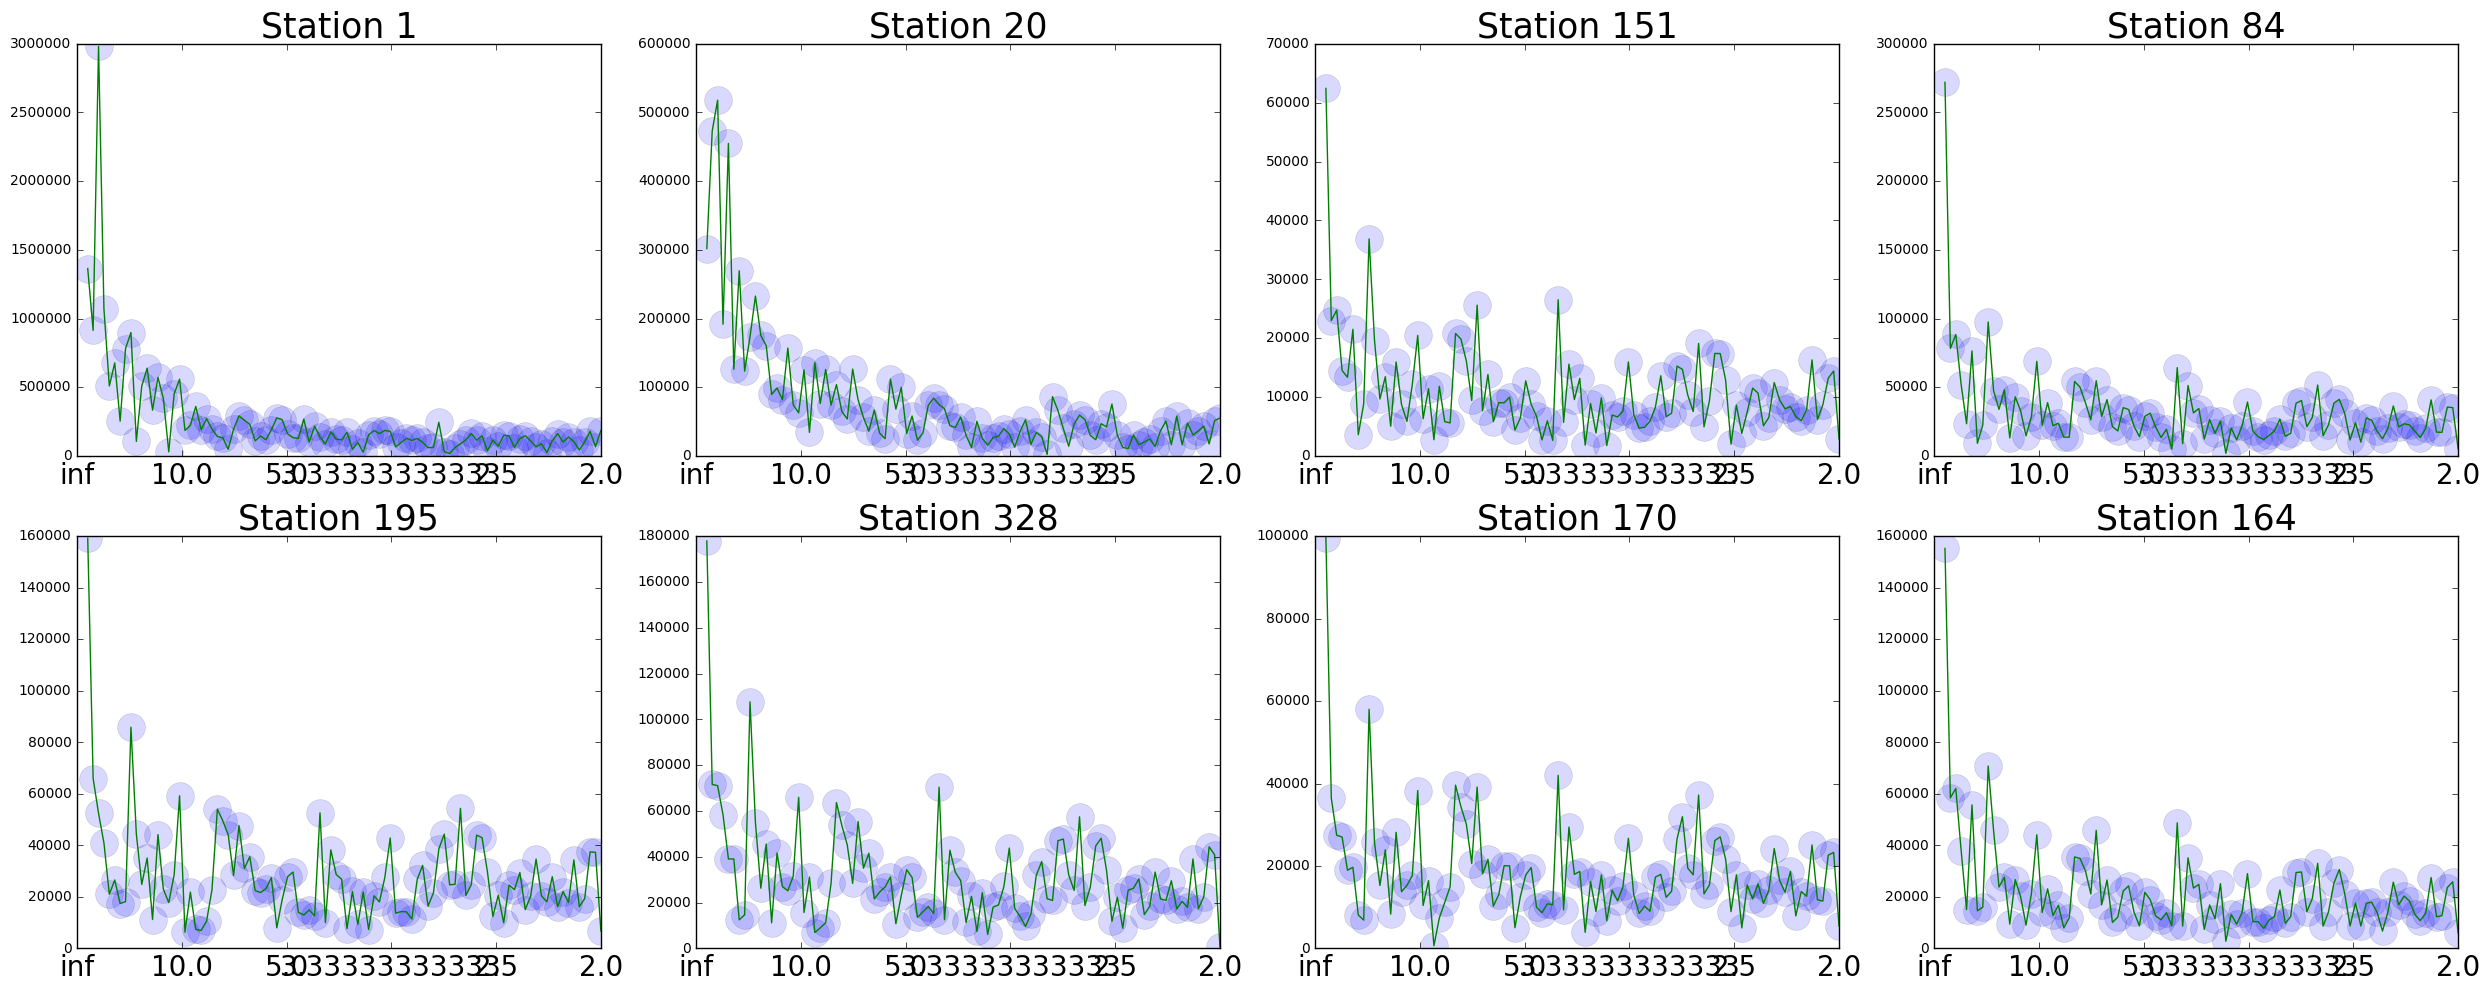

In [56]:
fig = pl.figure(figsize = (25, 10))
ax=[0] * 8

ax[0] = fig.add_subplot(241)
ax[1] = fig.add_subplot(242)
ax[2] = fig.add_subplot(243)
ax[3] = fig.add_subplot(244)
ax[4] = fig.add_subplot(245)
ax[5] = fig.add_subplot(246)
ax[6] = fig.add_subplot(247)
ax[7] = fig.add_subplot(248)

for i, a in enumerate([0,19,150,83,194,327,169,163]):
    ax[i].plot(np.fft.rfftfreq(N, 1.0)[2:],np.abs(np.fft.rfft(df_sum1[i]))[2:] , 'o', alpha=0.15, ms=20)
    ax[i].plot(np.fft.rfftfreq(N, 1.0)[2:],np.abs(np.fft.rfft(df_sum1[i]))[2:] , '-')
    ax[i].set_title('Station %d'%(a + 1), fontsize = 25)
    ax[i].set_xticklabels([ "%s"%(1/f) for f in ax[i].get_xticks()], fontsize=20)

fig.tight_layout()

#### Graph 6: Power spectrum for each of the 8 stations with most prominent annual periodicity trend

#### Because the power value may be biased due to the discrepancies in the rides number scales of different stations, which can be solved by a standardized power value. Hence, I plot the time series graphs for 8 stations to identify the annual periodicity better

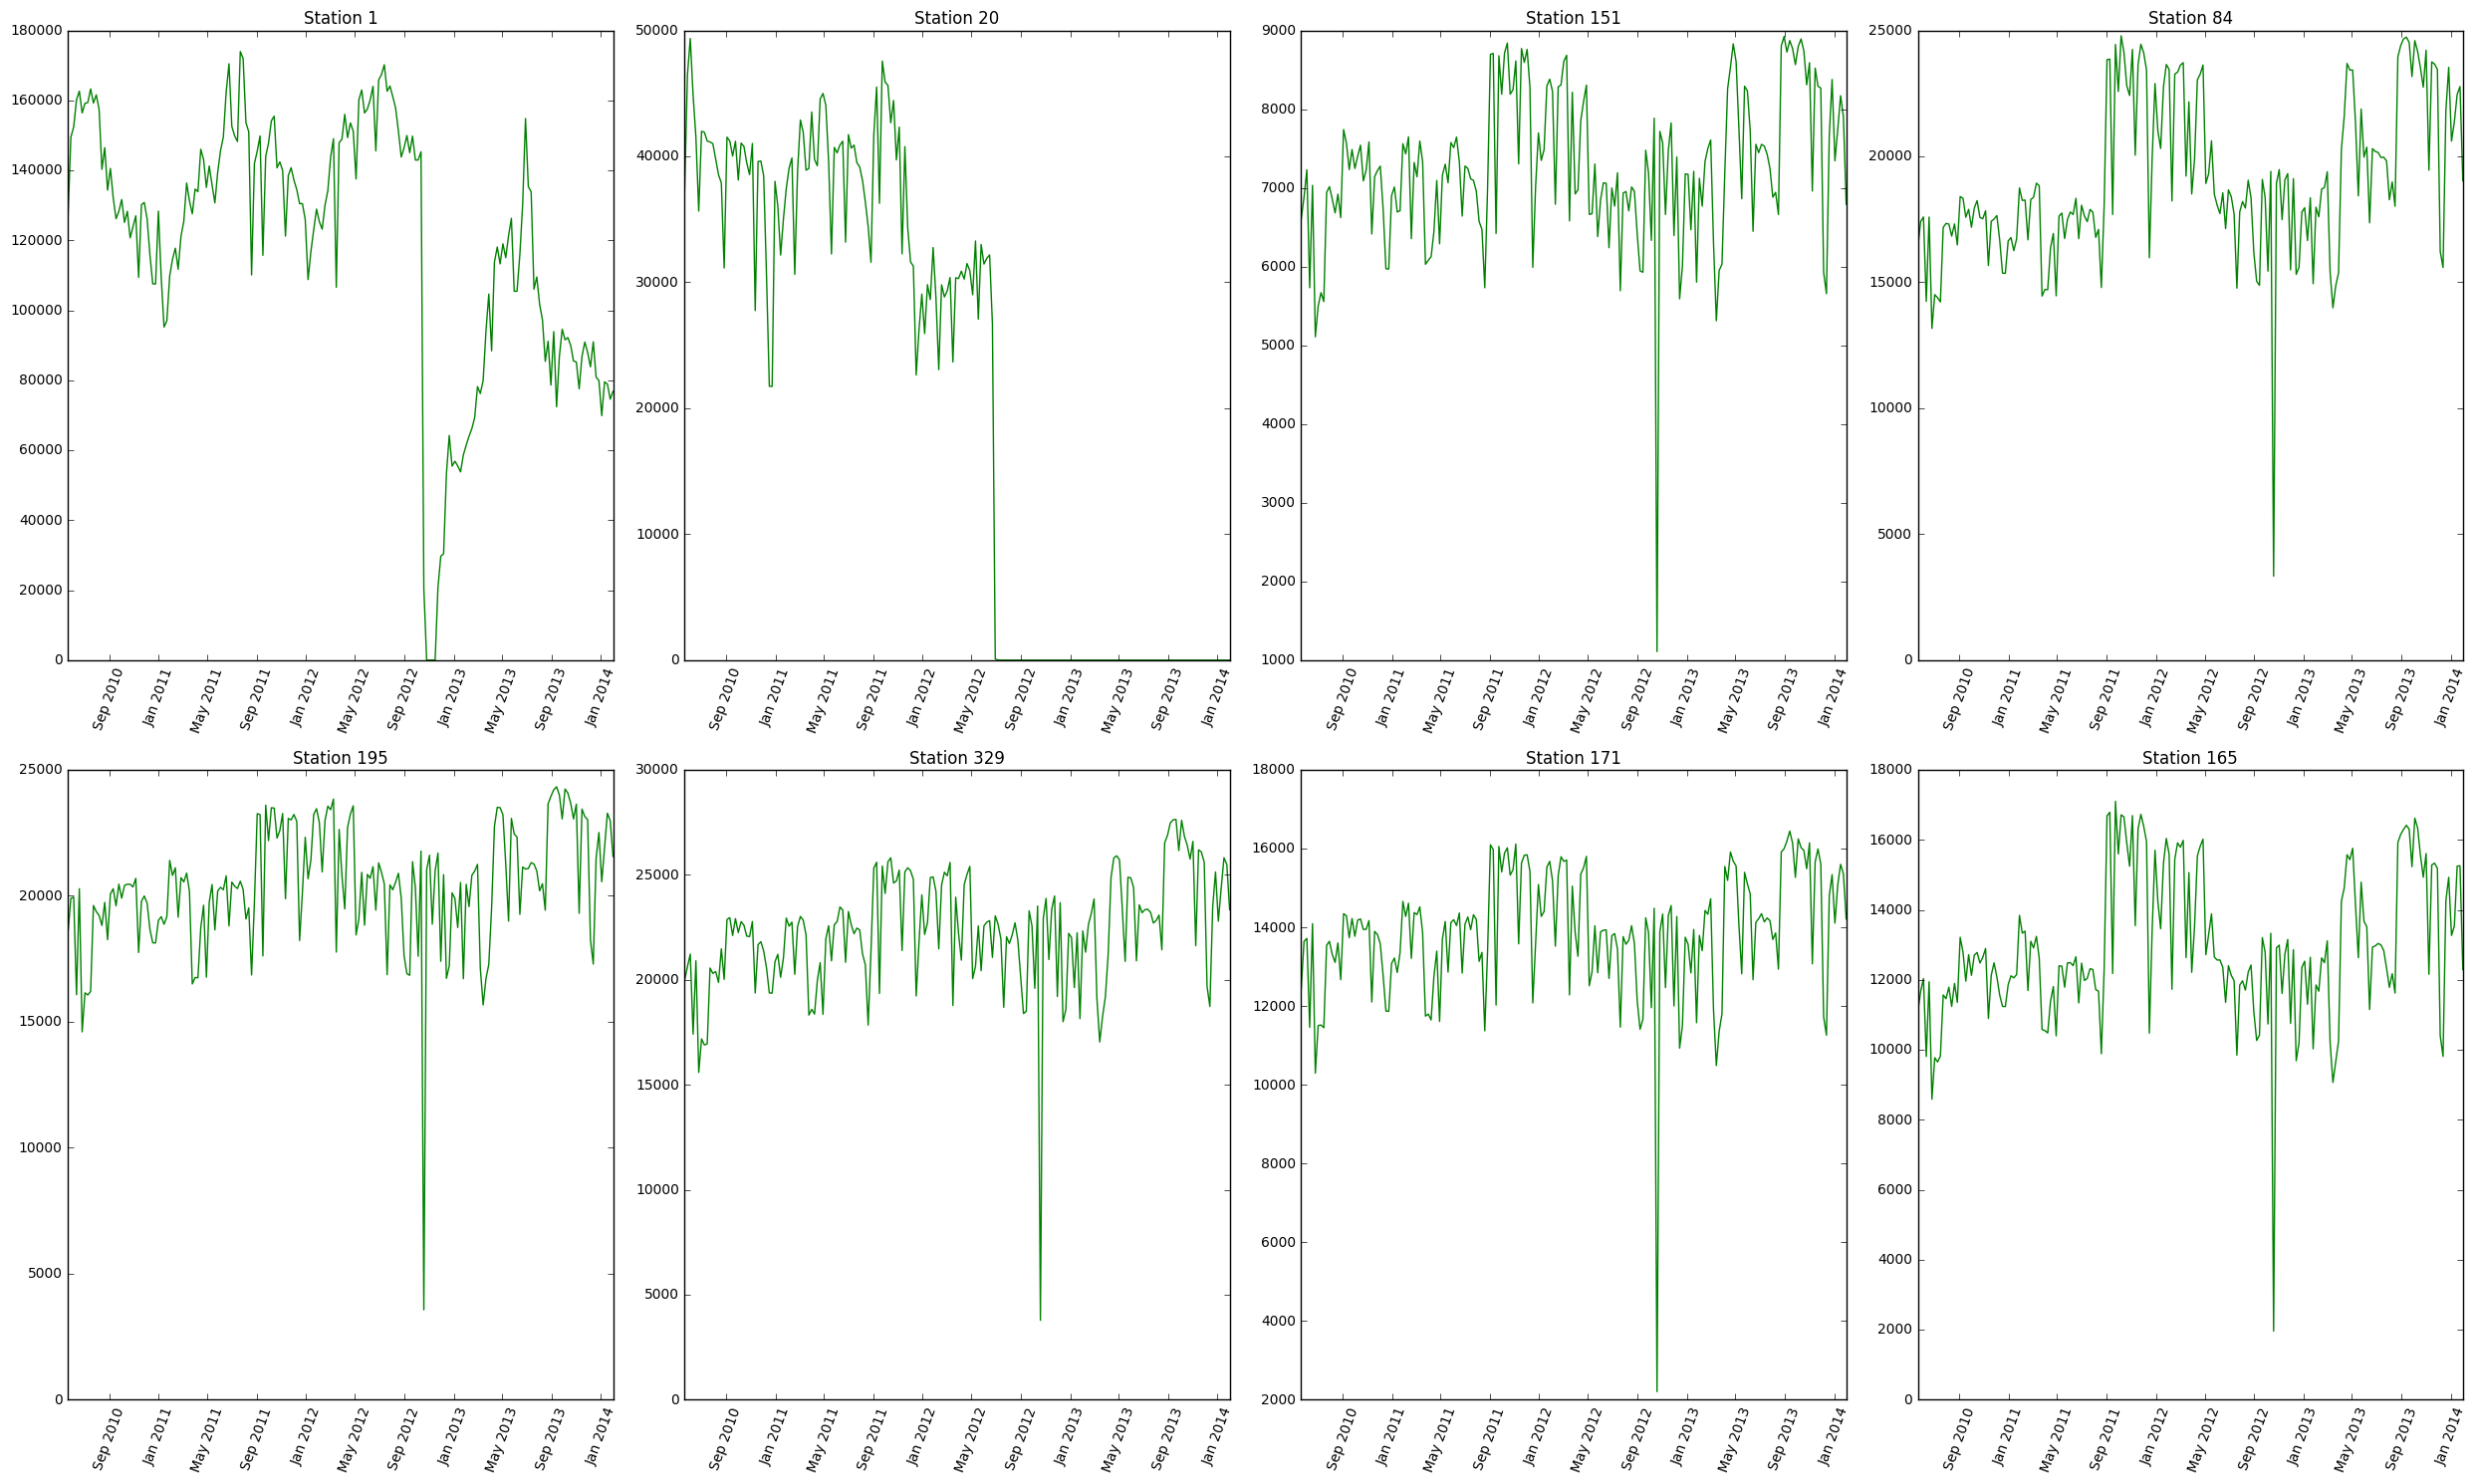

In [58]:
fig = pl.figure(figsize = (25, 15))
ax=[0] * 8

ax[0] = fig.add_subplot(241)
ax[1] = fig.add_subplot(242)
ax[2] = fig.add_subplot(243)
ax[3] = fig.add_subplot(244)
ax[4] = fig.add_subplot(245)
ax[5] = fig.add_subplot(246)
ax[6] = fig.add_subplot(247)
ax[7] = fig.add_subplot(248)

for i, a in enumerate([0,19,150,83, 194, 328, 170, 164]):
    ax[i].plot(date1, df_sum1[i], c='g')
    ax[i].set_title('Station %d'%(a + 1))
    pl.setp( ax[i].xaxis.get_majorticklabels(), rotation=70 )

fig.tight_layout()

#### Graph 7: Number of rides per week for each of the 8 stations with most prominent annual periodicity trend

#### From the time series graphs, I pick station 1, 84, 171 and 165 as the 4 stations with most prominent periodcity trend

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

In [31]:
tots = df.transpose(2,0,1).reshape(df.shape[2], df.shape[1] * df.shape[0]).T

In [32]:
tots.shape

(13800, 194)

In [33]:
tots = tots[tots.std(1) > 0]
tots.shape

(7660, 194)

In [34]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
vals.shape

(7660, 194)

#### Using the code from Applied Data Science class for the Elbow's definition

In [35]:
def elbow(data, K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [ ]:
elbow(vals, range(5,50))

In [ ]:
res = KMeans(random_state = 324,n_clusters = 20).fit(vals)

In [ ]:
vals.shape

In [ ]:
res.labels_.shape

In [ ]:
# This list is the cluster label for each of the 13800 time series
res.labels_

# HINTS: 


## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, dependingon the question) the appropriate dimension in different parts of the homework: when you need to work on the station level, collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average). The sum and average functions take an "axis" argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the dight axis.


# Possibly useful functions

I  used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
```
np.fft.rfft(mydata) 
```  

    will return the *real* part of the fourier transform (which is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math. All you need to know is that you need the real part). But what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the 
```
np.array.flatten()
np.array.reshape()
```
    array methods allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

